In [2]:
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from gudhi import bottleneck_distance
import pandas as pd
from multiprocess import Pool

In [3]:
import os, sys
sys.path.append("..")
import json

from src.toy_functions import Alpine01, PenHolder, Schwefel26, Tripod, UrsemWaves, Wavy, XinSheYang04
# from src.tools import HNSWNearestNeighbors
from src.tools import plot_barcodes
# from src.sublevel import graph as GetBarcodes

In [4]:
REPEATS = 200
DIMS = [2, 3, 4, 5, 6]
Ns = [1000, 2200, 4500, 10000, 22000, 45000, 100000, 220000,]# 1000000]
CREATE_GRAPHS = True
GRAPHS_PATH = 'knn_graphs'
BARCODES_PATH = 'barcodes'

In [ ]:
if not os.path.exists(GRAPHS_PATH):
    os.makedirs(GRAPHS_PATH)

for dim in DIMS:
    dim_path = os.path.join(GRAPHS_PATH, str(dim))
    if not os.path.exists(dim_path):
        os.makedirs(os.path.join(dim_path))
    
    for N in Ns:
        N_dim_path = os.path.join(dim_path, str(N))
        if not os.path.exists(N_dim_path):
            os.makedirs(os.path.join(N_dim_path))

## Creating Many Random NN graphs in a cube

In [ ]:
if CREATE_GRAPHS:
    for _ in tqdm(range(REPEATS)):
        for dim in DIMS:
            for N in Ns:
                x = np.random.rand(N, dim).astype(np.float32)
                graph, _ = HNSWNearestNeighbors(x, k=4*dim)
                
                name = str(np.random.randint(1e10)) + '.json'
                out_path = os.path.join(GRAPHS_PATH, str(dim), str(N), name)
                with open(out_path, 'w') as f:
                    json.dump({'x' : x.tolist(), 'knn' : graph.tolist()}, f)

## Computing Barcodes

In [ ]:
Fs = [Schwefel26, XinSheYang04, Alpine01, ]

In [ ]:
def barcode_single_thread(f, x_knn_path):
    with open(x_knn_path, 'r') as file:
        x_knn = json.load(file)
    x = np.array(x_knn['x'], dtype=np.float32) * (f.bounds[:, 1] - f.bounds[:, 0]) + f.bounds[:, 0]
    x = x.astype(np.float32)
    knn = np.array(x_knn['knn'], dtype=np.int32)
    del x_knn
    
    result = GetBarcodes(f(x), knn)

    result = pd.DataFrame(result)
    result.columns = [
        'birth', 'death', 'birth_swallowed_cluster',
        'id_dead_min', 'id_saddle', 'id_swallowed_min', 'dead_cluster_size',
        'swallowed_cluster_size', 'mean_height_cluster'
    ]
    return result.to_dict()

In [ ]:
for F in Fs:
    out_path = F.__name__
    for dim in DIMS:
        f = F(dim)
        dim_path = os.path.join(GRAPHS_PATH, str(dim))
        for N in tqdm(Ns):
            N_dim_path = os.path.join(dim_path, str(N))
            x_knn_paths = [os.path.join(GRAPHS_PATH, str(dim), str(N), name) for name in os.listdir(N_dim_path)]
                
            pool = Pool(32)
            results = list(pool.map(
                lambda path: barcode_single_thread(F(dim), path),
                x_knn_paths
            ))
            
            out_dir = os.path.join(BARCODES_PATH, F.__name__, str(dim), str(N))
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
                
            for result, name in zip(results, os.listdir(N_dim_path)):
                with open(os.path.join(out_dir, name), 'w') as file:
                    json.dump(result, file)
            del results
            pool.close()
            pool.terminate()

## Distance

In [ ]:
results = dict()

In [ ]:
for f in os.listdir(BARCODES_PATH):
    results[f] = dict()
    f_path = os.path.join(BARCODES_PATH, f)
    for dim in os.listdir(f_path):
        if dim in ['3', '4', '5', '6']:
            continue
        results[f][dim] = dict()
        f_dim_path = os.path.join(f_path, dim)
        for N in tqdm(os.listdir(f_dim_path)):
            f_dim_N_path = os.path.join(f_dim_path, N)
            barcode_sets = []
            for name in os.listdir(f_dim_N_path):
                file = open(os.path.join(f_dim_N_path, name), 'r')
                barcode_sets.append(pd.DataFrame(json.load(file))[['birth', 'death']].values)
                file.close()
#             barcode_sets = barcode_sets[:(len(barcode_sets) // 2) * 2]
            pool = Pool(32)
            results[f][dim][N] = list(
                pool.map(
                    lambda pair: bottleneck_distance(*pair),
                    zip(barcode_sets[::2], barcode_sets[1::2])
                ),
            )
        
            # EXTRA
            if np.inf in results[f][dim][N]:
                fail_pairs, fail_dists = barcode_sets, results[f][dim][N]
                raise Exception('')

In [ ]:
fail_pairs[2], fail_pairs[3]

In [ ]:
np.isinf(fail_pairs[2]).sum()

In [ ]:
np.isinf(fail_pairs[3]).sum()

In [ ]:
i = 5
plt.scatter(barcode_sets[i][:, 0], barcode_sets[i][:, 1])

In [ ]:
# with open('results2.json', 'w') as file:
#     json.dump(results, file)

In [6]:
with open('results2.json', 'r') as file:
    results = json.load(file)

## Plotting Results

In [16]:
from scipy import stats

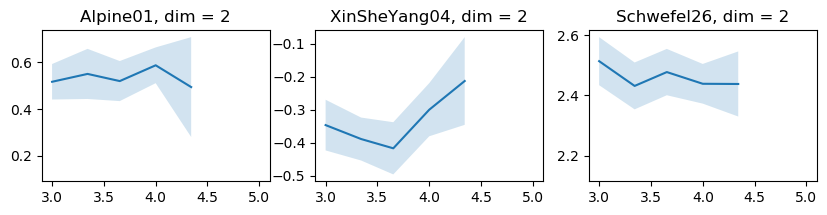

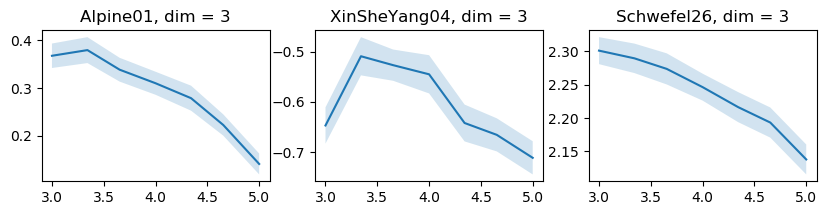

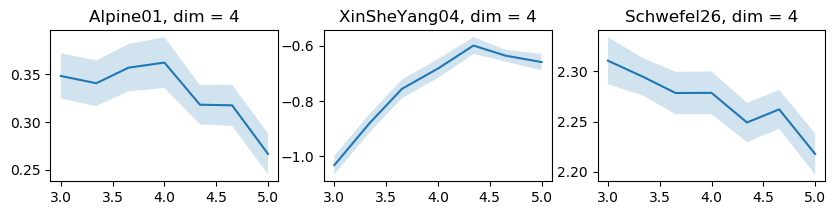

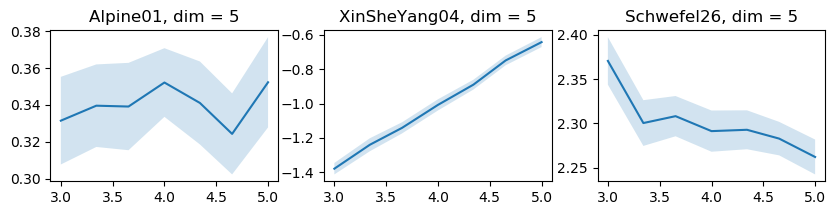

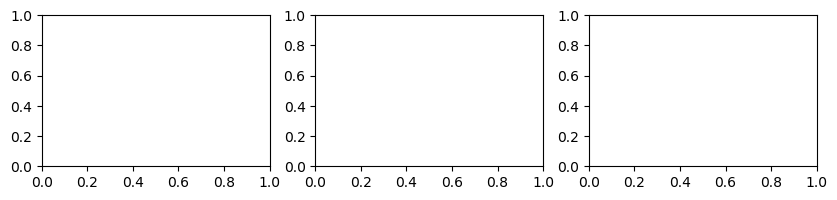

In [27]:
for dim in DIMS:
    fig, axes = plt.subplots(1, len(results.keys()), figsize=(10, 2), dpi=100)
    i = 0
    for f in results.keys():
        if str(dim) not in results[f].keys():
            continue
        Ns = []
        dist = []
        bottom, top = [], []
        for N in sorted([int(N) for N in results[f][str(dim)]]):
            Ns.append(np.log10(N))
            all_dist = np.array(results[f][str(dim)][str(N)])
#             print(f, N, np.mean(np.isinf(all_dist)))
            all_dist = all_dist[~np.isinf(all_dist)]
            all_dist = all_dist[~np.isnan(all_dist)]
            dist.append(np.mean(np.log10(all_dist)))
            b, t = stats.norm.interval(
                0.95,
                loc=np.mean(np.log10(all_dist)),
                scale=np.std(np.log10(all_dist)) / np.sqrt(len(all_dist))
            )
            bottom.append(b)
            top.append(t)
        axes[i].plot(Ns, dist, label=f)
        axes[i].fill_between(Ns, bottom, top, alpha=0.2)
        axes[i].set_title(f'{f}, dim = {dim}')
        i += 1
    fig.savefig(f'../pics/{dim}.png')
    plt.show()
#     ax.legend(loc='upper right')

## Trash

In [ ]:
fs = [
#     Alpine01(dim=6), #PenHolder(), Schwefel26(),
    #UrsemWaves(), VenterSobiezcczanskiSobieski(),
    #Wavy(dim=6), 
    XinSheYang04(dim=3), XinSheYang04(dim=4), 
]

R = 200
Ns = [1000, 2200, 4500, 10000, 22000, 45000, 100000, 220000, 450000, 1000000]

for f in tqdm(fs):
    name = f'{type(f).__name__}, dim={f.dim}'
    results[name] = []
    for N in Ns:
        results[name].append([])
        for _ in range(R):
            x = (np.random.rand(N, f.dim) * (f.bounds[:, 1] - f.bounds[:, 0]) + f.bounds[:, 0])
            graph, _ = HNSWNearestNeighbors(x, k=4*f.dim)

            result = GetBarcodes(f(x).astype(np.float32), np.array(graph, dtype=np.int32))

            result = pd.DataFrame(result)
            result.columns = [
                'birth', 'death', 'birth_swallowed_cluster',
                'id_dead_min', 'id_saddle', 'id_swallowed_min', 'dead_cluster_size',
                'swallowed_cluster_size', 'mean_height_cluster'
            ]
            results[name][-1].append(result)

In [ ]:
# import pickle
# with open('results.pkl', 'wb') as f:
#     pickle.dump(results, f)

In [ ]:
# fig, axes = plt.subplots(len(Points), min(Repeats, 5), figsize=(5 * Repeats, 5 * len(Points)), sharey=True)
# for points in range(len(Points)):
#     for repeat in range(min(Repeats, 5)):
#         plot_barcodes(
#             results[points][repeat],
#             ax=axes[points, repeat],
#             min_cluster_size=300,
#             title = f'{f}, n_points={Points[points]}'
#         )

In [ ]:
bottleneck = dict()
for f in tqdm(fs):
    name = f'{type(f).__name__}, dim={f.dim}'
    bottleneck[name] = []
    for i in range(len(Ns)):
        bottleneck[name].append([])
        for r in range(R // 2):
            bottleneck[name][-1].append(bottleneck_distance(
                results[name][i][r][['birth', 'death']].values,
                results[name][i][r + R // 2][['birth', 'death']].values
            ))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=200)

for f in tqdm(fs):
    name = f'{type(f).__name__}, dim={f.dim}'
#     if name == 'Tripod, dim=2' or name == 'VenterSobiezcczanskiSobieski, dim=2' or name == 'PenHolder, dim=2':
#         continue
    dist = np.array(bottleneck[name])
    dist[np.isinf(dist)] = np.nan
    
    ts = pd.Series(np.nanmean(np.log10(dist), axis=1), index=np.log10(Ns)).interpolate()
#     print(ts)
    ax.plot(ts, label=name)
ax.legend(framealpha=1., loc='upper right')
ax.set_ylabel('Average bottleneck distance\nbetween persistence diagrams\n of two random samples,\n$\log_{10}$ scale')
ax.set_xlabel('Sample size, $\log_{10}$ scale')